In [1]:
import pandas as pd
import networkx as nx
import geopandas as gpd
import shapely.geometry

import matplotlib
%matplotlib inline

import glob

In [2]:
nx.__version__

'2.1'

In [3]:
files = glob.glob("data/taxi_clean/*_od_v2.pkl")
files = files[0:1]

df = pd.concat(pd.read_pickle(f) for f in files)

def uniform_str(x):
    strd = str(x)
    while len(strd) < 7:
        strd = '0' + strd
    return strd
df["NODEID_O"] = df["NODEID_O"].apply(uniform_str)
df["NODEID_D"] = df["NODEID_D"].apply(uniform_str)
df["pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
df["dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])
del df['tpep_dropoff_datetime']
del df['tpep_pickup_datetime']

mn_nodes = gpd.read_file("data/mn_nodes.shp")
init_graph = nx.read_gpickle("data/mn_subgraph.pkl")

In [4]:
def first_average(g):
    travel_time = ((g["dropoff_datetime"] - g["pickup_datetime"]).mean().total_seconds() / 60.)
    res = g.iloc[0]
    res["tt_avg"] = travel_time
    res["n_trips"] = len(g)
    return res

df = df.groupby(["NODEID_O", "NODEID_D"]).apply(first_average)
del df["NODEID_O"]
del df["NODEID_D"]
df.reset_index(inplace=True)

In [7]:
# first trip filtering
df = df[(df["NODEID_O"] != df["NODEID_D"]) &
        (df["tt_avg"] > 120 / 60.) &
        (df["tt_avg"] < 3600 / 60.)].reset_index(drop=True)

In [8]:
import numpy as np
import toolz


S_trip = None
T_s = None
O_s = None

def trip_dist(trip):
    try:
        p = nx.algorithms.shortest_path(init_graph,
                                    trip["NODEID_O"], 
                                    trip["NODEID_D"])
    except Exception as e:
        print e
        print "=================".format(n1, n2)
        return np.nan
    edges = ((p[i], p[i+1]) for i in range(len(p) - 1))
    street_dist = sum(init_graph.get_edge_data(*e)['dist'] for e in edges)
    return street_dist

@toolz.curry
def trip_path(trip, graph=None):
    """
    Compute trip time (in hours)
    """
    global S_trip
    global T_s
    try:
        p = nx.algorithms.shortest_path(graph,
                                    trip["NODEID_O"], 
                                    trip["NODEID_D"])
        edges = ((p[i], p[i+1]) for i in range(len(p) - 1))
        for e in edges:
            S_trip.add(e)
            T_s[e].add(trip.name)

    except Exception as e:
        n1 = str(e).split(" ")[-1][:-1]
        n2 = str(e).split(" ")[-3]
        print "error on nodes {}, {}".format(n1, n2)
        return np.nan
    return ",".join(p)

bad = None

@toolz.curry
def trip_time(p,graph=None):
    global bad
    edges = ((p[i], p[i+1]) for i in range(len(p) - 1))
    t = 0.
    for e in edges:
        try:
            w = graph.get_edge_data(*e)['weight']
        except Exception as q:
            bad = p
            raise q
        t += w
    return t

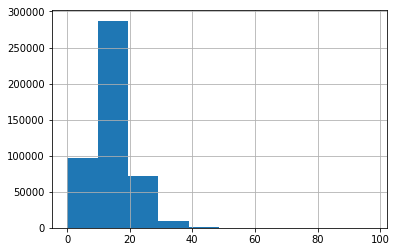

In [9]:
# second trip filtering
df["dist"] = df.apply(trip_dist, axis=1)
df.dropna(subset=["dist"], inplace=True)
df["speed"] = df["dist"] / (df["tt_avg"] / 60.)
df["speed"].hist()
df = df[(df["speed"] > 1) & (df["speed"] < 65)].reset_index(drop=True)

rel_err sum is -201605.768732
new_rel_err sum is -148906.792452
rel_err sum is -149029.112257
new_rel_err sum is -87434.481565
rel_err sum is -87297.0023851
new_rel_err sum is -29557.4325958
rel_err sum is -29599.6897577
new_rel_err sum is -22415.1549888
rel_err sum is -22327.4062167
new_rel_err sum is 20568.3027373
rel_err sum is 20770.2478534
new_rel_err sum is -6745.7851898
rel_err sum is -6727.31332038
new_rel_err sum is 31122.6401041
k updated to 1.2
new_rel_err sum is 20862.3298521
k updated to 1.15
new_rel_err sum is 13480.8473468
k updated to 1.1125
new_rel_err sum is 8140.03817596
k updated to 1.084375
new_rel_err sum is 4253.24881602
rel_err sum is 4292.78590326
new_rel_err sum is 11188.9970218
k updated to 1.2
new_rel_err sum is 8175.65353967
k updated to 1.15
new_rel_err sum is 6422.67036163
k updated to 1.1125
new_rel_err sum is 5423.54472926
k updated to 1.084375
new_rel_err sum is 4866.21118093
k updated to 1.06328125
new_rel_err sum is 4562.92334593
k updated to 1.04746

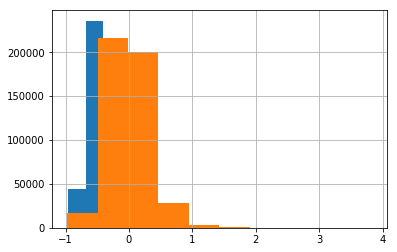

In [10]:
from collections import defaultdict

# iterative steps
again = True
done = False
base_graph = init_graph.copy()
while again:
    tt = trip_time(graph=base_graph)
    path = trip_path(graph=base_graph)
    again = False
    S_trip = set() # all touched streets
    T_s = defaultdict(set) # basically trips_by_street
    O_s = defaultdict(np.float64) # offset_by_street
    df["path"] = df.apply(path, axis=1).str.split(",")
    df["et"] = df["path"].apply(tt)
    df["rel_err"] = (df["et"] - df["tt_avg"]) / df["tt_avg"]
    df["rel_err"].hist() if not done else None
    done = True
    for street, trips in T_s.iteritems():
        trips_df = df.loc[trips]
        O_s[street] = ((trips_df["et"] - trips_df["tt_avg"]) * trips_df["n_trips"]).sum()
    k = 1.2
    print "rel_err sum is {}".format(df["rel_err"].sum())
    while True:
        g_c = base_graph.copy()
        tt2 = trip_time(graph=g_c)
        for street in S_trip:
            a, b = street # street connects nodes a and b
            e = base_graph.edges[street]
            if O_s[street] < 0:
                g_c[a][b]['weight'] = e["weight"] * k
            else:
                g_c[a][b]['weight'] = e["weight"] / k
        df["et_new"] = df["path"].apply(tt2)
        df["new_rel_err"] = (df["et_new"] - df["tt_avg"]) / df["tt_avg"]
        print "new_rel_err sum is {}".format(df["new_rel_err"].sum())
        if np.abs(df["new_rel_err"].sum()) < np.abs(df["rel_err"].sum()):
            df["et"] = df["et_new"]
            df["rel_err"] = df["new_rel_err"]
            again = True
            base_graph = g_c
            break
        else:
            print "k updated to {}".format(k)
            k = 1 + (k - 1) * .75
            if k < 1.0001:
                break            
                
df["rel_err"].hist()

In [12]:
nx.write_gpickle(base_graph,"data/base_graph_1st_pass_nx_{}.pkl".format(nx.__version__))

In [11]:
import networkx as nx
nx.algorithms.all_pairs_dijkstra_path_length(init_graph)

<generator object all_pairs_dijkstra_path_length at 0x7f9331fb6c30>

In [ ]:
for e, attrs in base_graph:
    

In [39]:
final_graph = base_graph.copy()
for e, attrs in final_graph.edges.iteritems():
    attrs["speed"] = attrs["weight"] / attrs["dist"]
    

In [40]:
final_graph.edges.iteritems().next()

((u'9000428', u'0021076'),
 {'dist': 0.11436198655596957,
  'ix': 9285,
  'speed': 6.207146688449705,
  'weight': 0.7098616261354163})

In [41]:
S = set(final_graph.edges.iterkeys())
ES = S
NS = S - S_trip
N_S = nodes_by_street = {s: set(final_graph.edges(s)) for s in S}
n_s_i = n_by_street = sorted({s: len(N_S[s].intersection(S_trip)) for s in NS}.iteritems(), key=lambda x: x[1], reverse=True)

for s, n in n_s_i:
    if n == 0:
        continue
    intersecting_speeds = [final_graph.edges[(e1,e2)]['speed'] for e1, e2 in N_S[s].intersection(ES)]
    final_e = final_graph.edges[s]
    v_s_i = sum(intersecting_speeds) / float(n)
    t_s_i = final_e["dist"] / v_s_i
    final_e["speed"] = v_s_i
    final_e["weight"] = t_s_i
    ES.add(s)
    NS = NS - set([s])

In [42]:
nx.write_gpickle(final_graph,"data/final_graph_1st_pass_nx_{}.pkl".format(nx.__version__))

In [23]:
old = 9285
thing = (u'9000428', u'0021076')
base_graph.edges.iteritems().next()[1]['ix'] = 9285

In [24]:
base_graph.edges.iteritems().next()

((u'9000428', u'0021076'),
 {'dist': 0.11436198655596957,
  'ix': 9285,
  'speed': 25.0,
  'weight': 0.7098616261354163})

In [ ]:
S_trip.__iter__().next()

In [ ]:
init_graph.edge[u'0066086']['0087506']['speed'] = 25.0

In [ ]:
init_graph.edge[u'0066086']['0087506']

In [ ]:
.0056284915 * 25

In [ ]:
pd.__version__

In [ ]:
import functools

In [ ]:
import toolz

In [ ]:
tt = toolz.curry(trip_time)

In [ ]:
tt(3)

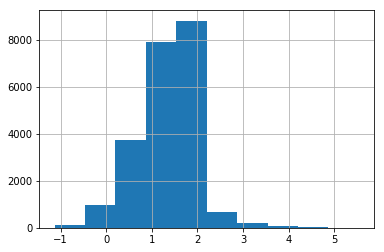

In [46]:
pd.Series(np.log(e["speed"]) for _, e in final_graph.edges.iteritems()).hist()

In [48]:
np.e**5

148.41315910257657